The task at hand is **given citations predict at least one author and provide the probability associated with the prediction**. For this we will use **KDD CUP 2003 dataset** as it contains research papers from arXiv from 1992 - 2003, and it also contains a **citation graph**. A **citation graph** is a directed acyclic graph(DAG) where each node represents a research paper and it's connection represents the citations in that research paper.

# Downloading and extraction of data
For this project I choose to use KDD CUP 2003's dataset. The dataset includes yearwise files which contains research papers. Each file(research paper) is given a unique id(string), and the file is of LaTex format. Each file contains 'Title', 'Authors', 'Abstract', 'Data', and 'Comments'. The dataset will also contain a citation graph, it is stored in a file which has two columns representing Original paper id, and citation paper id.

For **Downloading** I will be using *request* module, and for **extraction** I will be using *tarfile* module. The *request* module will help in first establishing a conectiong between the local system and the KDD server and then proceed to download the dataset which is in .tar format. The downloaded file is stored in the current directory, but will be extracted to a *Dataset* folder using *tarfile* module.

In [16]:
import requests
import tarfile
import os

if 'graphs' not in os.listdir('./'):
    os.makedirs('./graphs')

Download abstracts(Folder) which will contain yearwise folder and that will contain metadata related to the research paper.

In [ ]:
fname = 'hep-th-abs.tar.gz'
r = requests.get('http://www.cs.cornell.edu/projects/kddcup/download/' + fname)
open(fname , 'wb').write(r.content)

Extracting the downloaded .tar file into a Dataset/abs folder.

In [ ]:
tar = tarfile.open("./hep-th-abs.tar.gz")
tar.extractall("./Dataset/abs")
tar.close()

Now we will delete the .tar file as we have extracted the necessary files from it.

In [ ]:
os.remove("./hep-th-abs.tar.gz")

Following above steps for downloading and extracting citation graph.

In [ ]:
# Download
fname = 'hep-th-citations.tar.gz'
r = requests.get('http://www.cs.cornell.edu/projects/kddcup/download/' + fname)
open(fname , 'wb').write(r.content)

# Extract
tar = tarfile.open("hep-th-citations.tar.gz")
tar.extractall("./Dataset")
tar.close()

# Delete the .tar file
os.remove("./hep-th-citations.tar.gz")

Let's find out the total number of research papers whose metadata is available.

In [2]:
ADDRESS = "./Dataset/abs"
ADDRESS = [ADDRESS + '/' + date for date in os.listdir(ADDRESS)]
yearwise = {}
for i in ADDRESS:
    # Get date
    date = i.split('/')[-1]
    yearwise[date] = len(os.listdir(i))

Plot the yearwise distribution of the data

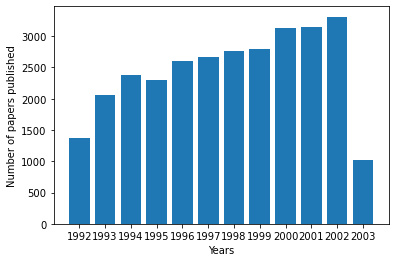

In [7]:
import matplotlib.pyplot as plt
names = list(yearwise.keys())
values = list(yearwise.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(yearwise)),values,tick_label=names)
plt.savefig('./graphs/yearwise_distribution.png')
plt.xlabel('Years')
plt.ylabel('Number of papers published')
plt.show()

Let's parse the citation graph. As our task is to get probability of prediction for original research paper given citation research paper, we will label the first column of the citation graph as Y, and second column as X.

In [14]:
import pandas as pd
import numpy as np

In [15]:
CITATIONS = "./Dataset/hep-th-citations"
citationGraph = pd.read_table(CITATIONS)
citationGraph.columns = [' ']
citationGraph = citationGraph.to_numpy()
citationGraphX, citationGraphY = [x[0].split(' ')[1] for x in citationGraph], [x[0].split(' ')[0] for x in citationGraph]

In [11]:
print(f'Number of edges in citation graphs: {len(citationGraphX)}')

Number of edges in citation graphs: 352806


Let's see distribution for number of citation per research paper to understand the problem a little better.

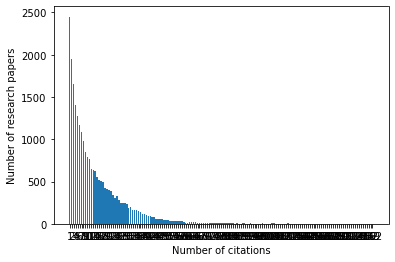

In [13]:
import collections
import matplotlib.pyplot as plt

Data = pd.DataFrame({'Original': citationGraphY, 'Cited': citationGraphX})
df = Data.groupby(Data.Original).size()
citationDistribution = {}
for i in df.to_numpy():
    if i in citationDistribution.keys():
        citationDistribution[i] = citationDistribution[i] + 1
    else:
        citationDistribution[i] = 1

citationDistribution = collections.OrderedDict(sorted(citationDistribution.items()))

names = list(citationDistribution.keys())
values = list(citationDistribution.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(citationDistribution)),values,tick_label=names)
plt.savefig('./graphs/citations_distribution.png')
plt.xlabel('Number of citations')
plt.ylabel('Number of research papers')
plt.show()

A lot of papers seem to have only one citations.

In [16]:
print(citationDistribution[1], citationDistribution[2], citationDistribution[3], citationDistribution[4], citationDistribution[5])

2449 1951 1657 1405 1272


## Preprocessing
In this step we will read all the metadata of a research paper, and extract 'TITLE', 'AUTHORS', 'ABSTRACT', and 'DATE'. Might and might not use some of the metadata extracted. I will create a dictionary where keys are the paper id and which maps to a dictionary of metadata.

It will look like this:
```
{
    ...
    '00001001': {
        'TITLE': 'Title of this research paper',
        'AUTHORS' [...List of authors...],
        'abs': 'Abstract of this paper',
        'DATE': DATE
    }
    ...
}
```

In [22]:
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

In [206]:
MAIN = {}
for date in ADDRESS:
    progressBar = tqdm(os.listdir(date))
    for f in progressBar:
        progressBar.set_description(f"Currently processing: {date.split('/')[-1]}")
        filename = f.split('.')[0] # 100100.abs = ['100100', 'abs']
        f = open(date + '/' + f) # Open the file
        LOCAL_MAIN = {}
        s = []
        slashes = 0
        for line in f.readlines(): # Read lines from the file
            firstWord = line.split(' ')[0]
            if(firstWord == "Title:"):
                # The line = 'Title: some title\n' and we remove substring 'Title: ' and '\n' from it
                title = line[len("Title: "): len(line) - 1]
                title = re.sub("\$(.*?)\$", "", title).strip().lower()
                title = nltk.word_tokenize(title)
                title = [re.sub("^([0-9]+)|([IVXLCM]+)\\.?$", "", w.upper()).lower() for w in title]
                i = 0
                while i < len(title):
                    if title[i] in stop_words or any(c.isdigit() for c in title[i]) or (len(title[i]) < 2 and (title[i] != '.' and title[i] != ',')):
                        title.pop(i)
                    else:
                        i = i + 1
                LOCAL_MAIN['TITLE'] = title
            elif(firstWord == "Authors:" or firstWord == "Author:"):
                """
                We do not want Organization details for now, the main reason behind this is because the organization detail
                is absent from a lot of papers in the dataset

                Observed: 1) The organization details are provided between '(' and ')'
                2) Authors names separators used are: "," or "and" or combination of both.
                """
                # Removing organization details using Regular Expression
                line = re.sub('\((.*?)\)', '', line).strip() # Remove (Univ. of xyz)
                line = re.sub('\(.*', '', line).strip() # Remove ( Univ. of xyz
                # Get list of authors
                li = []
                if(firstWord == "Authors:"):
                    line = line[len("Authors: "):]
                else:
                    line = line[len("Author: "):]
                authors = line.split("and") # Split with "and", it will split in two parts
                # If only 1 author then split on and will give us array with only 1 element
                if(len(authors) != 1):
                    # More than 1 author, the append the part after "and"
                    if len(authors[1].split(',')) != 1:
                        a = [i.strip().lower() for i in authors[1].split(',')]
                        li.extend(a)
                    else:
                        li.append(authors[1].lower())
                
                # Split with ","
                authors = authors[0].split(",")
                # Convert to lower()
                authors = [a.lower() for a in authors]
                # Merge the lists
                li.extend(authors)
                # Found that author strings might have trailing whitespaces 
                li = [i.strip() for i in li]
                LOCAL_MAIN['AUTHORS'] = li
            elif(firstWord == "Date:"):
                line = line[len("Date: "):]
                line = line.split('(')[0].strip()
                LOCAL_MAIN['DATE'] = line
            elif firstWord == '\\\\\n':
                slashes = slashes + 1
                continue
            if slashes >= 2:
                s.append(line[:-1])

        # Preprocessing related to abstracts of each paper
        full_abs = ' '.join(s)
        
        # Remove equations from abstract
        full_abs = re.sub("\$(.*?)\$", "", full_abs)
        # Replace '-' with whitespaces
        full_abs = re.sub("[-]", ' ', full_abs)
        # Remove words with digits and stopwords
        op = ''
        for word in full_abs.split(" "):
            if any(i.isdigit() for i in word) == False:
                op = op + ' ' + word
                
        full_abs = op.lower().strip()
        
        # split into sentences
        full_abs = nltk.sent_tokenize(full_abs)
        # Convert into tokens keeping in mind
        full_abs = [nltk.word_tokenize(sent) for sent in full_abs]

        for sent in full_abs:
            i = 0
            while i < len(sent):
                if sent[i] in stop_words or (len(sent[i]) < 2 and (sent[i] != '.' and sent[i] != ',')):
                    sent.pop(i)
                else:
                    i = i + 1
        LOCAL_MAIN['abs'] = full_abs
        MAIN[filename] = LOCAL_MAIN

Currently processing: 2003: 100%|██████████| 1019/1019 [00:04<00:00, 235.20it/s]


Let's look at the MAIN dict

In [207]:
print(MAIN['9210075']) # Change the last digit to see metadata related to other papers

{'DATE': 'Wed, 14 Oct 92 16:11:42 JST', 'TITLE': ['paragrassmann', 'differentia', 'calculus'], 'AUTHORS': ['a.b. kurdikov', 'a.t. filippov', 'a.p. isaev'], 'abs': [['explicit', 'general', 'constructions', 'paragrassmann', 'calculus', 'one', 'many', 'variables', 'given', '.'], ['relations', 'paragrassmann', 'calculus', 'quantum', 'groups', 'outlined', 'possible', 'physics', 'applications', 'briefly', 'discussed', '.'], ['paper', 'original', 'except', 'added', 'appendix', 'minor', 'changes', 'acknowledgements', 'references', '.'], ['important', 'note', 'paper', 'bears', 'title', 'dubna', 'preprint', 'identical', ',', 'containing', 'new', 'results', ',', 'extended', 'discussions', ',', 'references', '.']]}


Let's store MAIN in a file, I will use pickle for storing dict and list in files.

In [6]:
import pickle

In [208]:
with open('./main.txt', 'wb') as outfile:
    pickle.dump(MAIN, outfile)

If you want to read MAIN from the file

In [7]:
MAIN = {}
with open('./main.txt', 'rb') as outfile:
    MAIN = pickle.load(outfile)

In [10]:
print(MAIN['9201001'])

{'DATE': 'Tue Dec 31 23:54:17 MET 1991 +0100', 'TITLE': ['combinatorics', 'modular', 'group', 'kontsevich', 'integrals'], 'AUTHORS': ['j.-b. zuber', 'c. itzykson'], 'abs': [['study', 'algebraic', 'aspects', 'kontsevich', 'integrals', 'generating', 'functions', 'intersection', 'theory', 'moduli', 'space', 'review', 'derivation', 'virasoro', 'kdv', 'constraints', '.'], ['intersection', 'numbers', 'kontsevich', 'integral', 'main', 'theorem', 'expansion', 'characters', 'schur', 'functions', 'proof', 'first', 'part', 'theorem', 'grassmannians', 'kdv', 'matrix', 'airy', 'equation', 'virasoro', 'highest', 'weight', 'conditions', 'genus', 'expansion', 'singular', 'behaviour', 'painlev', 'equation', '.'], ['generalization', 'higher', 'degree', 'potentials']]}


Let's first see the distribution of number of authors per research paper, this will help us decide the number of authors in the feature set.

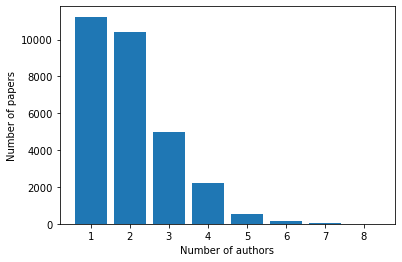

In [11]:
import collections
import matplotlib.pyplot as plt

authorPerPaper = {}
for x, val in MAIN.items():
    numAuthors = len(val['AUTHORS'])
    if numAuthors not in authorPerPaper.keys():
        authorPerPaper[numAuthors] = 0
    authorPerPaper[numAuthors] = authorPerPaper[numAuthors] + 1

authorPerPaper = collections.OrderedDict(sorted(authorPerPaper.items()))


names = list(authorPerPaper.keys())
values = list(authorPerPaper.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(authorPerPaper)),values,tick_label=names)
plt.savefig('./graphs/number_of_author_distribution.png')
plt.xlabel('Number of authors')
plt.ylabel('Number of papers')
plt.show()

In [253]:
print(authorPerPaper)

OrderedDict([(1, 11238), (2, 10433), (3, 4966), (4, 2236), (5, 524), (6, 126), (7, 30), (8, 2)])


We will consider first three authors of any paper as features for a model.

Let's see how many authors cite their own paper using a pie chart

In [17]:
origTocited = {}
for i, val in enumerate(citationGraphY):
    origAuth =  MAIN[val]['AUTHORS']
    citedAuth = MAIN[citationGraphX[i]]['AUTHORS']
    if val not in origTocited.keys():
        origTocited[val] = []
        origTocited[val].append(origAuth)
    origTocited[val].append(citedAuth)

In [19]:
citedOneself, citedOneselfDict = 0, {}
for x, y in origTocited.items():
    origAuth = y[0]
    citedAuth = y[1:]
    flag = False
    for cited in citedAuth:
        for i in origAuth:
            if i in cited:
                citedOneself = citedOneself + 1
                citedOneselfDict[x] = y
                flag = True
                break # We found an author who has cited an older paper, no need to look further
        if flag:
            # If we find even one of the authors who has cited an older work we don't look further and go to next paper
            break

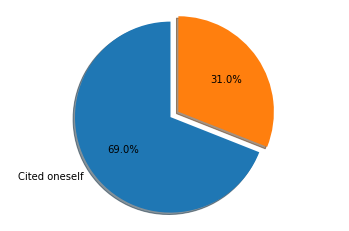

Fraction of authors who cite their own work is 69.2234685073339


In [21]:
import matplotlib.pyplot as plt
from math import floor
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
pre = floor(citedOneself / len(set(citationGraphX)) * 100)
labels = 'Cited oneself', ''
sizes = [pre, 100 - pre]
explode = (0.1, 0.0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.savefig('./graphs/cite_oneself.png')
plt.show()
print(f'Fraction of authors who cite their own work is {(citedOneself / len(set(citationGraphX)) * 100)}')

Of these papers, let's see the distribution of number of paper's they cite which were written by them. I will find the ratio of number of older papers cited by total number of papers cited and take floor of the ratio.

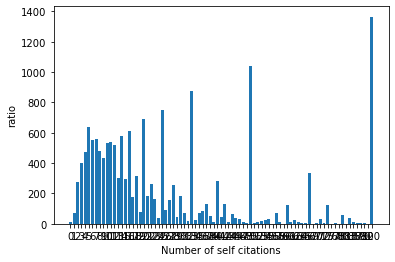

In [29]:
from math import floor
citedOneselfDistribution = {}
for x, y in citedOneselfDict.items():
    total_cited, oneself = 0, 0
    
    origAuth = y[0]
    citedAuth = y[1:]
    total_cited = len(citedAuth)
    
    for row in citedAuth:
        for oAuth in origAuth:
            if oAuth in row:
                oneself = oneself + 1
                break
    
    ratio = floor((oneself / total_cited) * 100)
    
    if ratio not in citedOneselfDistribution.keys():
        citedOneselfDistribution[ratio] = 0
    citedOneselfDistribution[ratio] = citedOneselfDistribution[ratio] + 1
    
citedOneselfDistribution = collections.OrderedDict(sorted(citedOneselfDistribution.items()))


names = list(citedOneselfDistribution.keys())
values = list(citedOneselfDistribution.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(citedOneselfDistribution)),values,tick_label=names)
plt.savefig('./graphs/cited_oneself_ratio_distribution.png')
plt.xlabel('Number of self citations')
plt.ylabel('ratio')
plt.show()

In [30]:
print(citedOneselfDistribution)

OrderedDict([(0, 10), (1, 73), (2, 273), (3, 398), (4, 475), (5, 635), (6, 555), (7, 556), (8, 482), (9, 436), (10, 531), (11, 536), (12, 517), (13, 301), (14, 581), (15, 296), (16, 611), (17, 179), (18, 313), (19, 80), (20, 694), (21, 181), (22, 261), (23, 165), (24, 41), (25, 753), (26, 94), (27, 157), (28, 253), (29, 48), (30, 185), (31, 74), (32, 19), (33, 877), (34, 25), (35, 73), (36, 85), (37, 132), (38, 51), (39, 9), (40, 285), (41, 44), (42, 132), (43, 14), (44, 65), (45, 38), (46, 31), (47, 15), (48, 7), (50, 1043), (51, 4), (52, 9), (53, 19), (54, 27), (55, 30), (56, 1), (57, 69), (58, 11), (59, 1), (60, 125), (61, 9), (62, 26), (63, 10), (64, 8), (65, 2), (66, 337), (69, 1), (70, 6), (71, 32), (72, 7), (75, 122), (76, 1), (77, 6), (78, 1), (80, 61), (81, 1), (83, 35), (85, 14), (87, 8), (88, 6), (90, 2), (92, 1), (100, 1365)])


Let's find out how come so many papers have 100% cited oneself, i.e they have only cited their own papers.

In [42]:
searchIds = []
for x, y in citedOneselfDict.items():
    total_cited, oneself = 0, 0
    
    origAuth = y[0]
    citedAuth = y[1:]
    total_cited = len(citedAuth)
    
    for row in citedAuth:
        for oAuth in origAuth:
            if oAuth in row:
                oneself = oneself + 1
                break
    
    ratio = floor((oneself / total_cited) * 100)
    
    if ratio == 100:
        print(f'Paper id: {x} and metadata: {y}')
        searchIds.append(x)
        break

Paper id: 0001004 and metadata: [['adam d. helfer'], ['andrew s. i. d. lang', 'adam d. helfer']]


In [43]:
def getAllCitations(X, Y, id):
    """
        Here, X is the Paper and Y is the citations in that paper.
    """
    indexs = [i for i, x in enumerate(X) if x == id]
    ret = [y for i, y in enumerate(Y) if i in indexs]
    return ret

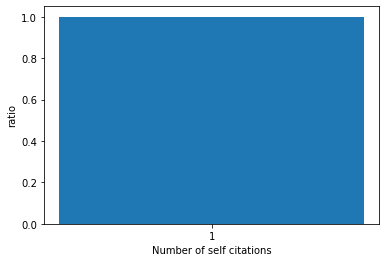

OrderedDict([(1, 1)])


In [45]:
distribution = {}
for ids in searchIds:
    citationsList = getAllCitations(citationGraphY, citationGraphX, searchId)
    if len(citationsList) not in distribution.keys():
        distribution[len(citationsList)] = 0
    distribution[len(citationsList)] = distribution[len(citationsList)] + 1
    

distribution = collections.OrderedDict(sorted(distribution.items()))
names = list(distribution.keys())
values = list(distribution.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(distribution)),values,tick_label=names)
plt.xlabel('Number of self citations')
plt.ylabel('ratio')
plt.show()

print(distribution)

As we can see from the above code and graph, I tried to find out the how come there are so many papers who have 100% cited oneself. It is because they have only one citation in the citation graph. This may can because the dataset considers papers from 1992 - 2003.

From below paper we will be able to see that the authors of a paper frequently cite their older works that are relevant for their current paper.

**NOTE**: The first list is the authors of a research paper and rest of the lists are authors of cited papers.

In [249]:
origTocited['0005036']

[['barton zwiebach', 'nicolas moeller', 'ashoke sen'],
 ['nathan berkovits'],
 ['per kraus', 'jeffrey a. harvey', 'petr horava'],
 ['washington taylor'],
 ['per kraus', 'jeffrey a. harvey'],
 ['barton zwiebach', 'nathan berkovits', 'ashoke sen', ''],
 ['washington taylor', 'nicolas moeller'],
 ['r. tatar', 'r. de mello koch', 'a. jevicki', 'm. mihailescu'],
 ['j. a. harvey', 'd. kutasov', 'e. j. martinec'],
 ['joris raeymaekers', 'pieter-jan de smet'],
 ['amer iqbal', 'asad naqvi'],
 ['n. itzhaki', 'nadav drukker', 'david j. gross'],
 ['g. moore'],
 ['juan m.', 'curtis g. callan', 'igor r. klebanov', 'andreas w. w. ludwig'],
 ['l. thorlacius', 'j. polchinski'],
 ['n.p. warner', 'p. fendley', 'h. saleur'],
 ['nathan berkovits'],
 ['rob potting', 'alan kostelecky'],
 ['stephen h.', 'michael r. douglas', 'daniel kabat', 'philippe pouliot', ''],
 ['barton zwiebach', 'matthias r. gaberdiel'],
 ['barton zwiebach'],
 ['ashoke sen'],
 ['ashoke sen'],
 ['ashoke sen'],
 ['edward witten'],
 ['v. 

Let's look at the distribution of lenght of a research paper's title.

**NOTE**: The title is preprocessed, hence all the stopwords are removed. This was done as this step will help us figure out the limits for lenght of title if used as feature for a model.

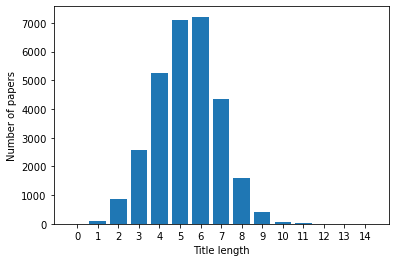

In [257]:
lenDistribution = {}

for i, val in MAIN.items():
    titleLenght = len(val['TITLE'])
    if titleLenght not in lenDistribution.keys():
        lenDistribution[titleLenght] = 0
    lenDistribution[titleLenght] = lenDistribution[titleLenght] + 1
    

lenDistribution = collections.OrderedDict(sorted(lenDistribution.items()))

names = list(lenDistribution.keys())
values = list(lenDistribution.values())

plt.bar(range(len(lenDistribution)),values,tick_label=names)
plt.savefig('./graphs/Title_length_distribution.png')
plt.xlabel('Title length')
plt.ylabel('Number of papers')
plt.show()

## Training and test dataset
Create **training and test** data, we will split the unique ids in X to get a training dataset. While mapping X to Y we will take 0.1 from each id as part of the test dataset.

In [37]:
unique_X, unique_Y = list(set(citationGraphX)), list(set(citationGraphY))

In [221]:
X_train_ids = unique_X[:20]
X_train, X_test, y_train, y_test = [], [], [], []
for x in X_train_ids:
    idxs = [i for i, val in enumerate(citationGraphY) if val == x ] # All matching index with id=x
    idxs_train, idxs_test = idxs[:int(len(idxs) * 0.9)], idxs[int(len(idxs)*0.9):]
    # Given idx find authors from cited
    for i in idxs_train:
        X_train.append(MAIN[citationGraphX[i]]['AUTHORS'])
        y_train.append(MAIN[x]['AUTHORS'])
    for i in idxs_test:
        X_test.append(MAIN[citationGraphX[i]]['AUTHORS'])
        y_test.append(MAIN[x]['AUTHORS'])

print(f'Training dataset size: {len(X_train)} \nTest dataset size: {len(X_test)}')

Training dataset size: 268 
Test dataset size: 42


### Network graph
A network graph of the training dataset to better understand the dataset for this task. I did not select the entire dataset as you will see with just 10 unique ids the plot will be dense. If we slice more unique ids we will see a very dense network graph.

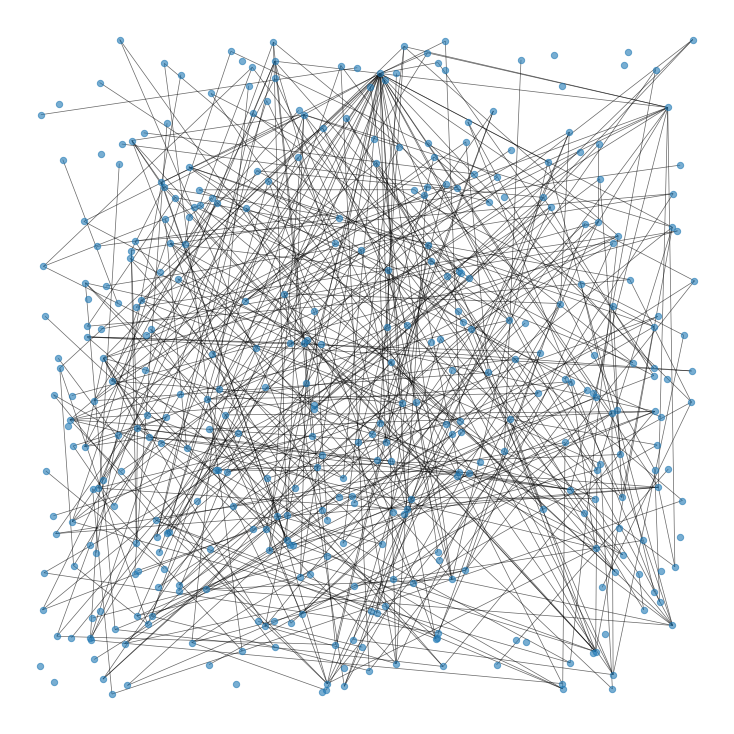

In [211]:
import networkx as nx
import matplotlib.pyplot as plt

def drawNetworkGraph(X, Y):
    """
        X = [List of ...[...List of citation paper...]...]
        Y = [List of ...[...List of research paper...]...]
    """
    G = nx.Graph()

    x_authToy_auth = {}

    unique_auths = []
    for row in X:
        unique_auths.extend(row)
        for author in row:
            for rowy in Y:
                unique_auths.extend(rowy)
                for authory in row:
                    if author not in x_authToy_auth.keys():
                        x_authToy_auth[author] = []
                    x_authToy_auth[author].append(authory)

    unique_auths = list(set(unique_auths))

    # Add nodes
    for auth in unique_auths:
        G.add_node(auth)

    # Add transitions
    for auth in unique_auths:
        if auth in x_authToy_auth.keys():
            for authy in x_authToy_auth[auth]:
                G.add_edge(auth, authy)

    # Draw the graph
    plt.figure(figsize=(10,10))

    pos = nx.random_layout(G, seed=23)
    nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

    plt.show()

drawNetworkGraph(X_train, y_train)

### One hot encoding for authors
This will map an author to a number which can then be feed to a model for training and making predictions. First I create a *AUTHOR_LIST* dict that acts as the function for mapping input author to a number. Then I create a encoding function that will take an X, Y and MAP as arguments, it will then **Numericalize** the X and Y using the MAP.

In [222]:
# OneHot encoding of authors
AUTHOR_LIST = []
for val in tqdm(X_train):
    AUTHOR_LIST.extend([i.strip() for i in val if i.strip() != ''])
for val in tqdm(y_train):
    AUTHOR_LIST.extend([i.strip() for i in val if i.strip() != ''])

# Get unique authors
AUTHOR_LIST = list(set(AUTHOR_LIST))
print(f'\nUnique authors: {len(AUTHOR_LIST)}')
# 0 => unknown, 1 => padding
# idx + 1, so 0 is not used to map any known author
AUTHOR_LIST = {author:(idx + 2) for idx,author in enumerate(AUTHOR_LIST)}

100%|██████████| 268/268 [00:00<00:00, 265927.01it/s]
Unique authors: 371



In [223]:
# Encoding the authors
def encoding(X, Y, dict_list):
    for i, val in enumerate(X):
        X[i] = [AUTHOR_LIST[j] if j in AUTHOR_LIST.keys() else 0 for j in val]
        X[i] = X[i][:3]
        while len(X[i]) < 3:
            X[i].append(1)
    for i, val in enumerate(Y):
        Y[i] = [AUTHOR_LIST[j] if j in AUTHOR_LIST.keys() else 0 for j in val]
        Y[i] = Y[i][:2]
        while len(Y[i]) < 2:
            Y[i].append(1)
    return X, Y

X_train, y_train = encoding(X_train, y_train, AUTHOR_LIST)
X_test, y_test = encoding(X_test, y_test, AUTHOR_LIST)

Shuffle training and test data.

In [224]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

## Training the model

### Defining accuracy function
I have defined accuracy as ability of the function to predict an author from the given outputs. The position of the author predicted does not matter. This is somewhat similar to the **subset accuracy** but the change if we find 1 author from the list of possible authors, it will consider it as a hit.

In [219]:
def acc(y_true, y_pred):
    total_hit, examples = 0, 0
    idxs = []
    for idx, row in enumerate(y_true):
        flag = True
        pred_row = y_pred[idx]
        for i in row:
            if i >= 2:
                examples = examples + 1
                break # Found 1 author whose name we know and is not padding
        for auth in pred_row:
            if auth >= 2 and auth in row:
                total_hit = total_hit + 1
                idxs.append(idx)
                break
    
    return (total_hit / examples), idxs

In [ ]:
def subset_accuracy(y_true, y_pred):
    total_hit, examples = 0, 0
    for row in y_true:
        examples = examples + len(row)
    
    for auth in pred_row:
        if auth in row:
            total_hit = total_hit + 1
    
    return (total_hit / examples)

A **Classifier chain** tries to convert a non-multioutput model to predict multioutput. This is done via follow way:
```
For given input x -> Model1                                  -> y1

                x -> Model2 + y1(Previous models prediction) -> y2

                x -> Model3 + y2                             -> y3
                
And so on.
```

In [225]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.multioutput import ClassifierChain

model = RadiusNeighborsClassifier(radius=500, weights='distance')
model = ClassifierChain(model)

model.fit(X_train, y_train)
pred = model.predict(X_test)
acc_score, true_idx = acc(y_test, pred)
acc_score

0.23809523809523808

The below function will take in input X(Authors of citations) and return name of a possible author in the original paper with probability.

In [230]:
def getAuthor(X, map, model):
    """
        X = Input
        map = Dict that maps author to a number
        model
    """
    mapdash = {y:x for x, y in map.items()}
    pred = model.predict(X)[0]
    predProb = model.predict_proba(X)[0]
    maxProb, idx = 0, 0

    predIdx = [i for i,j in enumerate(pred) if j >= 2]

    if len(predIdx) == 0:
        return "UNK", 1.0
    
    for i, j in enumerate(predProb):
        if j > maxProb and i in predIdx:
            maxProb = j
            idx = i

    retAuthor = mapdash[pred[idx]]
    return retAuthor, maxProb

In [232]:
# Get author for citation authors
getAuthor([X_test[10]], AUTHOR_LIST, model), getAuthor([X_test[20]], AUTHOR_LIST, model), getAuthor([X_test[-1]], AUTHOR_LIST, model)

(('ramzi r. khuri', 0.028861725162316814),
 ('edward witten', 0.125),
 ('ramzi r. khuri', 0.03280443759032756))

**Dependencies**
1. Numpy
2. Pandas
3. Tqdm
4. matplotlib
5. sklearn
6. NLTK
7. networkx